In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [2]:
# Loading Data
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')

labels_names =['Stadium','Building','Traffic Sign','Forest','Flowers',
              'Street','Classroom','Bridge','Statue','Lake']

print(data_train.shape, labels_train.shape)

(270000, 3124) (3124,)


In [3]:
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import prewitt_h,prewitt_v

Class  Building


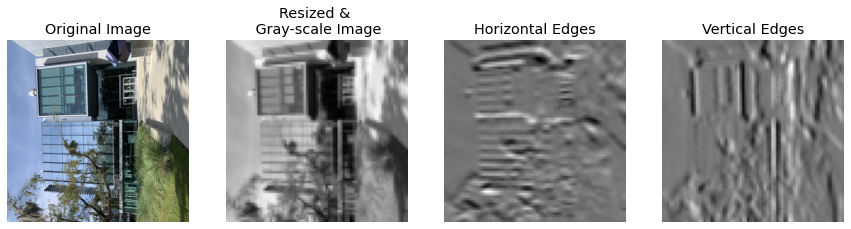

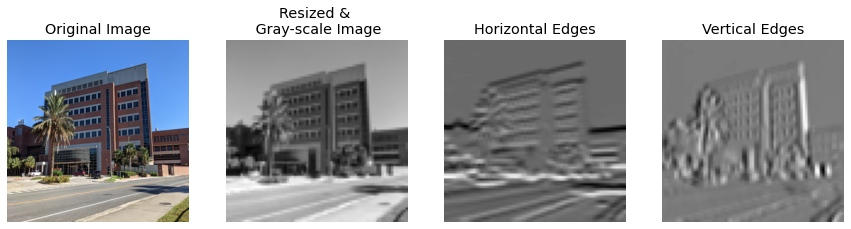

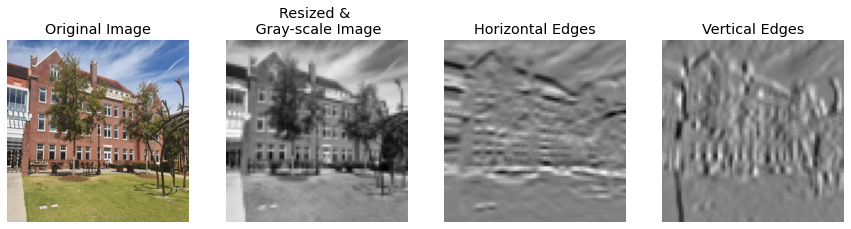

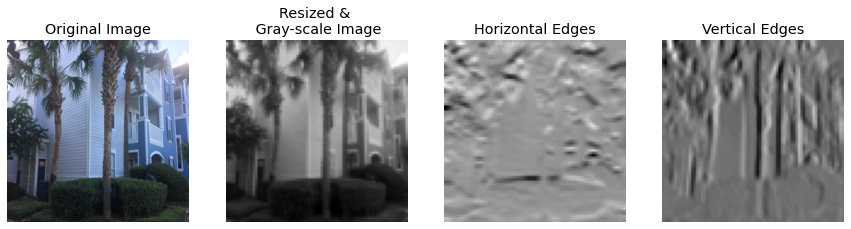

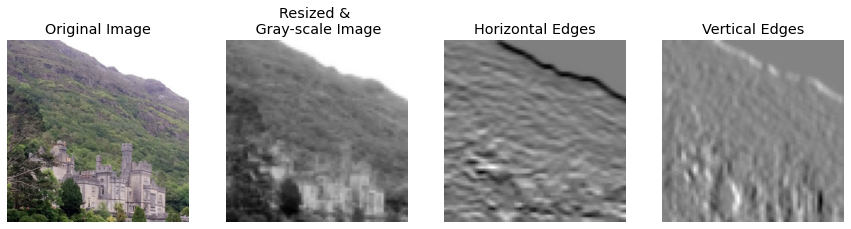

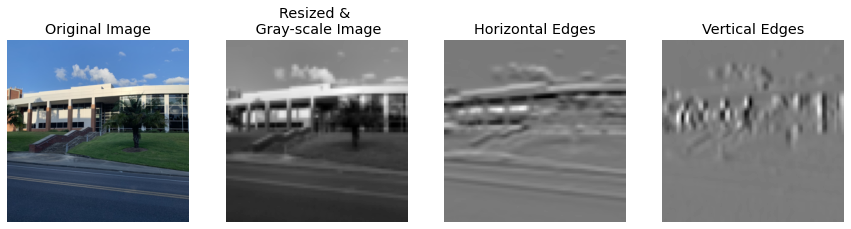

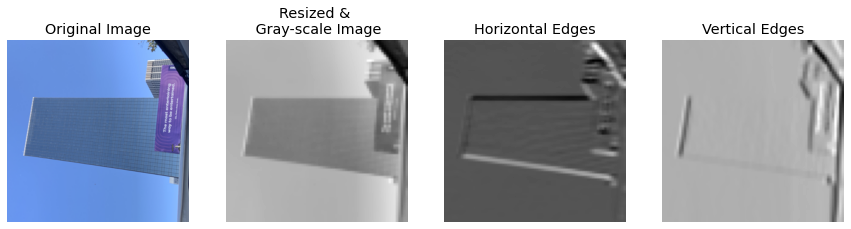

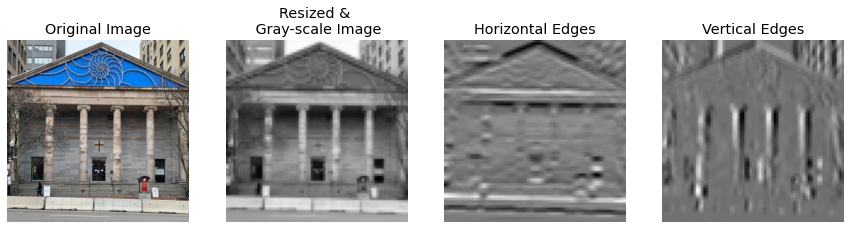

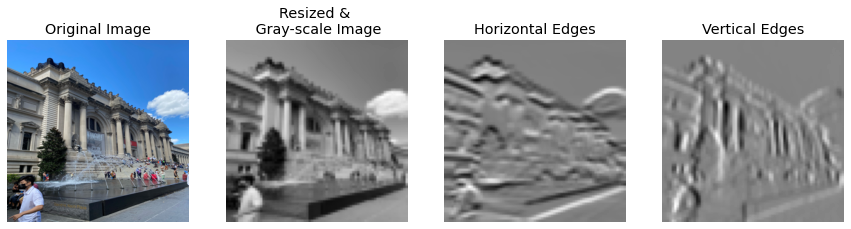

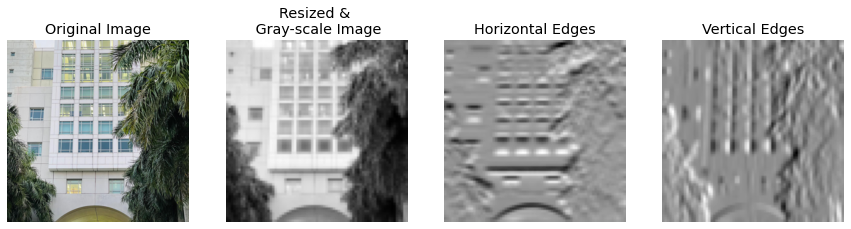

In [4]:
# Parameters for plotting
ll = 2 # class
print('Class ',labels_names[ll-1])

# Permutes the index locations for class ll
rnd_sample = npr.permutation(np.where(labels_train==ll)[0])

# Plot the Vertical and Horizontal edges detection of gray-scale images
for i in range(10):
    image_original = data_train[:,rnd_sample[i]].reshape(300,300,3)
    image_resized = resize(image_original, (image_original.shape[0] // 4, image_original.shape[1] // 4, 3),
                       anti_aliasing=True) # resizing image 
    image = rgb2gray(image_resized) # converting it to gray-scale
    #calculating horizontal edges using prewitt kernel
    edges_prewitt_horizontal = prewitt_h(image)
    #calculating vertical edges using prewitt kernel
    edges_prewitt_vertical = prewitt_v(image)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1); plt.imshow(image_original); plt.axis('off'); plt.title('Original Image');
    plt.subplot(1,4,2); plt.imshow(image, cmap='gray'); plt.axis('off'); plt.title('Resized & \n Gray-scale Image');
    plt.subplot(1,4,3); plt.imshow(edges_prewitt_horizontal, cmap='gray')
    plt.axis('off'); plt.title('Horizontal Edges')
    plt.subplot(1,4,4); plt.imshow(edges_prewitt_vertical, cmap='gray')
    plt.axis('off'); plt.title('Vertical Edges');

In [5]:
# Obtain the Edge Detectors Features for all Samples
features_edges = []
for i in range(data_train.shape[1]):
    image = rgb2gray(resize(data_train[:,i].reshape((300,300,3)), (300 // 4, 300 // 4, 3),
                       anti_aliasing=True))
    edges_prewitt_horizontal = prewitt_h(image).ravel()[:,np.newaxis]
    edges_prewitt_vertical = prewitt_v(image).ravel()[:,np.newaxis]
    if i==0:
        features_edges = np.vstack((edges_prewitt_horizontal, edges_prewitt_vertical))
    else:
        features_edges = np.hstack((features_edges, 
                                   np.vstack((edges_prewitt_horizontal, edges_prewitt_vertical))))
features_edges = features_edges.T
features_edges.shape

(3124, 11250)

___

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report

## Scaling and Partitioning Data

In [8]:
# Input Data
X = features_edges
y = labels_train

# Applying different normalization transformations
scaler_mm = MinMaxScaler()
scaler_st = StandardScaler()
Xmm = scaler_mm.fit_transform(X)
Xst = scaler_st.fit_transform(X)

# N - no. of samples
# D - no. of features
N, D = X.shape

# Finding random locations for training set
train_idx = np.random.choice(range(N), size=int(0.8*N),replace=False)
test_idx  = np.setxor1d(range(N), train_idx)

# Training and Test Sets without normalization
X_train, y_train = X[train_idx,:], y[train_idx]
X_test, y_test = X[test_idx,:], y[test_idx]

# Training and Test Sets using Min-Max Scaling
X_train_mm, y_train_mm = Xmm[train_idx,:], y[train_idx]
X_test_mm, y_test_mm = Xmm[test_idx,:], y[test_idx]

# Training and Test Sets using Standardization
X_train_st, y_train_st = Xst[train_idx,:], y[train_idx]
X_test_st, y_test_st = Xst[test_idx,:], y[test_idx]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2499, 11250) (625, 11250) (2499,) (625,)


## k-Nearest Neighbors

In [9]:
print('Without Normalization\n')
print('Finding Best k value...')
grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': np.arange(2,100,1)})
grid.fit(X_train, y_train)
grid.best_score_

Without Normalization



0.1388561122244489

In [10]:
grid.best_params_

{'n_neighbors': 2}

In [11]:
# Training the best model
model = grid.best_estimator_
model.fit(X_train, y_train)
y_predict_KNN = model.predict(X_test) # Predict labels for test set

# Performance measures
print('Accuracy: ', 100*accuracy_score(y_test, y_predict_KNN),'%\n')
print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict_KNN),'\n')
print(classification_report(y_test, y_predict_KNN))

Accuracy:  14.56 %

Confusion Matrix:
 [[36  2  8  1  1  0  0  0  0 11]
 [26  6 17  1  0  0  0  1  2  5]
 [29  2 16  1  0  0  0  3  6 11]
 [19  0 24  1  0  0  0  0  1  7]
 [31  1 13  1  2  0  0  0  7 12]
 [23  3 19  3  0  0  0  0  3 10]
 [19  6 12  2  0  2  5  3  1 16]
 [31  3 16  1  0  0  0  4  2  9]
 [29  1 19  3  0  0  0  0  6 10]
 [29  1 13  0  0  0  0  0  2 15]] 

              precision    recall  f1-score   support

         1.0       0.13      0.61      0.22        59
         2.0       0.24      0.10      0.14        58
         3.0       0.10      0.24      0.14        68
         4.0       0.07      0.02      0.03        52
         5.0       0.67      0.03      0.06        67
         6.0       0.00      0.00      0.00        61
         7.0       1.00      0.08      0.14        66
         8.0       0.36      0.06      0.10        66
         9.0       0.20      0.09      0.12        68
        10.0       0.14      0.25      0.18        60

    accuracy                    

___

In [12]:
print('Using Min-Max Scaling\n')
print('Finding Best k value...')
grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': np.arange(2,100,1)})
grid.fit(X_train_mm, y_train_mm)
grid.best_score_, grid.best_params_

Using Min-Max Scaling

Finding Best k value...


(0.13325290581162325, {'n_neighbors': 2})

In [13]:
# Training the best model
model = grid.best_estimator_
model.fit(X_train_mm, y_train_mm)
y_predict_KNN = model.predict(X_test_mm) # Predict labels for test set

# Performance measures
print('Accuracy: ', 100*accuracy_score(y_test_mm, y_predict_KNN),'%\n')
print('Confusion Matrix:\n',confusion_matrix(y_test_mm, y_predict_KNN),'\n')
print(classification_report(y_test_mm, y_predict_KNN))

Accuracy:  14.399999999999999 %

Confusion Matrix:
 [[39  2  5  1  1  0  0  0  0 11]
 [30  6  9  0  0  0  0  1  1 11]
 [33  2 11  1  0  0  0  3  6 12]
 [23  0 19  1  0  0  0  1  1  7]
 [32  0 12  0  2  0  0  0  7 14]
 [25  3 17  2  0  0  0  0  3 11]
 [25  5 10  0  0  1  5  3  1 16]
 [34  3 14  0  0  0  0  4  2  9]
 [27  2 16  2  0  0  0  0  6 15]
 [33  1  8  0  0  0  0  0  2 16]] 

              precision    recall  f1-score   support

         1.0       0.13      0.66      0.22        59
         2.0       0.25      0.10      0.15        58
         3.0       0.09      0.16      0.12        68
         4.0       0.14      0.02      0.03        52
         5.0       0.67      0.03      0.06        67
         6.0       0.00      0.00      0.00        61
         7.0       1.00      0.08      0.14        66
         8.0       0.33      0.06      0.10        66
         9.0       0.21      0.09      0.12        68
        10.0       0.13      0.27      0.18        60

    accuracy       

___

In [14]:
print('Using Standardization\n')
print('Finding Best k value...')
grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': np.arange(2,100,1)})
grid.fit(X_train_st, y_train_st)
grid.best_score_, grid.best_params_

Using Standardization

Finding Best k value...


(0.13205370741482966, {'n_neighbors': 2})

In [15]:
# Training the best model
model = grid.best_estimator_
model.fit(X_train_st, y_train_st)
y_predict_KNN = model.predict(X_test_st) # Predict labels for test set

# Performance measures
print('Accuracy: ', 100*accuracy_score(y_test_st, y_predict_KNN),'%\n')
print('Confusion Matrix:\n',confusion_matrix(y_test_st, y_predict_KNN),'\n')
print(classification_report(y_test_st, y_predict_KNN))

Accuracy:  14.399999999999999 %

Confusion Matrix:
 [[42  0  6  1  1  0  0  0  0  9]
 [38  5  4  0  0  0  0  1  3  7]
 [40  2  8  0  0  0  0  3  5 10]
 [30  0 10  1  0  0  0  1  1  9]
 [39  1  7  0  2  0  0  0  8 10]
 [34  3  9  1  0  0  0  0  4 10]
 [28  2 10  0  0  1  5  3  1 16]
 [41  3  6  0  0  0  0  4  3  9]
 [38  0 11  2  0  0  0  0  6 11]
 [36  0  5  0  0  0  0  0  2 17]] 

              precision    recall  f1-score   support

         1.0       0.11      0.71      0.20        59
         2.0       0.31      0.09      0.14        58
         3.0       0.11      0.12      0.11        68
         4.0       0.20      0.02      0.04        52
         5.0       0.67      0.03      0.06        67
         6.0       0.00      0.00      0.00        61
         7.0       1.00      0.08      0.14        66
         8.0       0.33      0.06      0.10        66
         9.0       0.18      0.09      0.12        68
        10.0       0.16      0.28      0.20        60

    accuracy       